In [1]:
from tensorflow.keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [2]:
print(x_train.shape) # 50000 張圖片, 32x32 圖片, 3 channel(RGB)
print(x_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [3]:
print(y_train.shape)
print(y_train[0:10]) # 每個數值代表一個物件

(50000, 1)
[[6]
 [9]
 [9]
 [4]
 [1]
 [1]
 [2]
 [7]
 [8]
 [3]]


### 圖片特徵縮放
加快收斂

In [4]:
print(x_train[0][0][0])
# min-max normalization
x_train_norm = x_train.astype('float32')/255
x_test_norm = x_test.astype('float32')/255
print(x_train_norm[0][0][0])

[59 62 63]
[0.23137255 0.24313726 0.24705882]


### 標籤轉 one-hot 編碼

In [5]:
from tensorflow.keras import utils
y_train_onehot = utils.to_categorical(y_train, 10)
y_test_onehot = utils.to_categorical(y_test, 10)

## 建立和訓練捲積網路

### 卷積層
不須將圖片拉平，**可保留原圖片空間結構**

##### Kernel 卷積核
想像成管子裡的濾鏡用來看圖片，224 * 224 圖片用 3 * 3 的濾鏡管子慢慢看，實際上該管子上的濾鏡會有**權重**。

- 該數量可透過 `filters` 設定
- 該尺寸可透過 `kernel_size` 設定

##### 卷積運算與 feature maps
透過卷積核和圖片進行點對點相乘，並將值加起來，接著產生 feature maps

- 卷積滑動
    - 做完一次點對點相乘後，需繼續看圖片(管子濾鏡無法一次看全部)，因此要移動，移動的範圍稱**卷積步長(stride)**
    - 可透過 `strides` 設定步長，`strides=(1,1)` 第一元素是右移，第二個是下移

##### 權重與偏值初始設定
- 權重
    - `kernel_initializer` 設定，[官網](https://www.tensorflow.org/api_docs/python/tf/keras/initializers)
- 偏值
    - `bias_initializer`
    - 不使用偏值 `use_bias=False`
##### 卷積核個數
使用 `filters` 設定

##### padding
原始圖片上補上像素值 0，如果希望 feature maps 與原始圖片一樣，可使用此方式。
使用 `padding` 設置，`vaild` 為不使用



[convolutional-networks](http://cs231n.github.io/convolutional-networks/)

### Pooling Layer
對 feature maps 進行特徵挑選。
- MaxPooling
    - 透過設定的檢視窗口(`pool_size`)觀察特徵，並取最大值出來，並配合著 `strides` 移動
- AveragePooling
    - 將窗口內的值加總，除以窗口內特徵數取平均值，並配合著 `strides` 移動
    
##### 降維方式
可透過 `Pooling` 進行縮小特徵尺寸，也可以使用 `strides` 的卷積層做。當然前者效果會最好。

### Flatten
拉成 1D 的向量，等待送入 `Dense`。無須參數調整

### Dense Layer
該輸入變成是從 CNN 擷取出精華

### Dropout
減緩神經網路**Overfitting**，不算層只是對資料進行單純操作。此操作也會減少特徵相依性。
`Dropout(0.25)` 表示隨機丟棄 25% 神經元


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

cnn = Sequential()
cnn.add(Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(32, 32, 3))) #((3*3)*3+1)*32 = (((kernel)*channel)+bias)*filters
cnn.add(Dropout(0.25))
cnn.add(MaxPooling2D((2,2)))

cnn.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
cnn.add(Dropout(0.25))
cnn.add(MaxPooling2D((2,2)))

cnn.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
cnn.add(Dropout(0.25))
cnn.add(MaxPooling2D((2,2)))

cnn.add(Flatten())
cnn.add(Dropout(0.25))
cnn.add(Dense(1024, activation='relu'))
cnn.add(Dropout(0.25))
cnn.add(Dense(10, activation='softmax'))

In [7]:
print(cnn.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         7

In [17]:
cnn.get_weights() # 查看權重和偏值

[array([[[[-0.07712825,  0.11369286, -0.07880474,  0.05297362,
            0.2380712 , -0.03765684,  0.07825649,  0.14605266,
           -0.09671338,  0.03105191, -0.02903735, -0.24025999,
            0.02564999, -0.0332218 , -0.07180765,  0.05919013,
            0.03325255,  0.05663097,  0.1007261 , -0.04083727,
           -0.06629199,  0.07318049, -0.13471608, -0.02404794,
            0.17545432, -0.06569207,  0.12219375,  0.02001286,
           -0.01993313,  0.04031309,  0.11286137,  0.03965145],
          [-0.03404987, -0.02480945, -0.17340976,  0.07023761,
            0.16484915, -0.01288365, -0.12907201,  0.01246143,
            0.10275986,  0.12387654, -0.03731479, -0.0331179 ,
            0.16858691,  0.09795058,  0.01706309, -0.13106637,
           -0.03050602, -0.0035661 , -0.17044638, -0.12290234,
           -0.06086448, -0.06862576,  0.10579292, -0.07811292,
            0.04093992, -0.11570305,  0.01167804,  0.01056684,
           -0.02604673,  0.06367811, -0.11589793, -0.0

### 訓練配置


In [8]:
cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

### 進行訓練

In [9]:
history = cnn.fit(x=x_train_norm, # sample
                  y=y_train_onehot, # label
                  batch_size=128, # 每批用 128 筆資料進行訓練
                  epochs=20,# 20 個訓練週期
                  validation_split=0.1 # 從訓練資料拿 10% 作為驗證資料
                 )

Train on 45000 samples, validate on 5000 samples
Epoch 1/20
45000/45000 [==============================] - 14s 314us/sample - loss: 1.5686 - acc: 0.4323 - val_loss: 1.3979 - val_acc: 0.5346
Epoch 2/20
45000/45000 [==============================] - 10s 228us/sample - loss: 1.1624 - acc: 0.5863 - val_loss: 1.1520 - val_acc: 0.6322
Epoch 3/20
45000/45000 [==============================] - 10s 227us/sample - loss: 1.0155 - acc: 0.6404 - val_loss: 1.0045 - val_acc: 0.6914
Epoch 4/20
45000/45000 [==============================] - 10s 224us/sample - loss: 0.9031 - acc: 0.6813 - val_loss: 0.9728 - val_acc: 0.6908
Epoch 5/20
45000/45000 [==============================] - 10s 225us/sample - loss: 0.8290 - acc: 0.7086 - val_loss: 0.9124 - val_acc: 0.7174
Epoch 6/20
45000/45000 [==============================] - 10s 229us/sample - loss: 0.7485 - acc: 0.7361 - val_loss: 0.8241 - val_acc: 0.7414
Epoch 7/20
45000/45000 [==============================] - 10s 227us/sample - loss: 0.6945 - acc: 0.7555 -

In [10]:
import matplotlib.pyplot as plt

# 繪製線圖 (可將訓練時所傳回的損失值或準確率等歷史記錄繪製成線圖)
# history: 內含一或多筆要繪資料的字典, 例如：{'loss': [4,2,1,…], 'acc': [2,3,5,…]}
# keys: 以 tuple 或串列指定 history 中要繪製的 key 值, 例如：('loss', 'acc')
# title: 以字串指定圖表的標題文字
# xyLabel: 以 tuple 或串列指定 x, y 軸的說明文字, 例如：('epoch', 'Accuracy')
# ylim: 以 tuple 或串列指定 y 軸的最小值及最大值, 例如 (1, 3), 超出範圍的值會被忽略
# size: 以 tuple 指定圖的尺寸, 預設為 (6, 4) (即寬 6 高 4 英吋)
def plot(history_dict, keys, title=None, xyLabel=[], ylim=(), size=()):
    lineType = ('-', '--', '.', ':')    # 線條的樣式, 畫多條線時會依序採用
    if len(ylim)==2: plt.ylim(*ylim)    # 設定 y 軸最小值及最大值
    if len(size)==2: plt.gcf().set_size_inches(*size)  # size預設為 (6,4)
    epochs = range(1, len(history_dict[keys[0]])+1)  # 計算有幾週期的資料
    for i in range(len(keys)):   # 走訪每一個 key (例如 'loss' 或 'acc' 等)
        plt.plot(epochs, history_dict[keys[i]], lineType[i])  # 畫出線條
    if title:   # 是否顯示標題欄
        plt.title(title)
    if len(xyLabel)==2:  # 是否顯示 x, y 軸的說明文字
        plt.xlabel(xyLabel[0])
        plt.ylabel(xyLabel[1])
    plt.legend(keys, loc='best') #upper left')  # 顯示圖例 (會以 key 為每條線的說明)
    plt.show()  # 顯示出畫好的圖

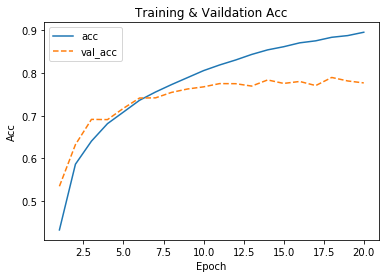

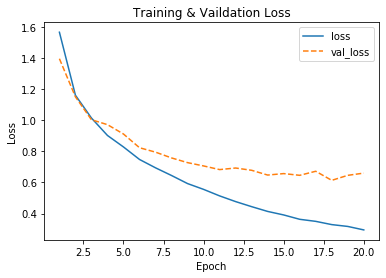

In [11]:
plot(history.history, ('acc', 'val_acc'), 'Training & Vaildation Acc', ('Epoch', 'Acc'))
plot(history.history, ('loss', 'val_loss'), 'Training & Vaildation Loss', ('Epoch', 'Loss'))

In [12]:
cnn.save('C:\\Users\\User\\Desktop\\kreas\\CNN\\cifar10.h5')

### 評估

In [13]:
test_loss, test_val = cnn.evaluate(x_test_norm, y_test_onehot)
print('loss:', test_loss)
print('val:', test_val)

10000/10000 [==============================] - 2s 247us/sample - loss: 0.6817 - acc: 0.7695
loss: 0.6816833820819854
val: 0.7695


### 預測

In [14]:
pred_prop = cnn.predict(x_test_norm)
print(pred_prop[0])

[3.3861116e-04 8.3557321e-03 2.7256100e-03 8.5827035e-01 3.4542768e-03
 2.1645728e-02 8.0310322e-02 2.3175019e-04 2.3838311e-02 8.2932960e-04]


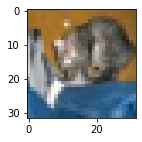

In [15]:
fig = plt.gcf()
fig.set_size_inches(2, 2)
plt.imshow(x_test[0])
plt.show()

In [16]:
pred_class = cnn.predict_classes(x_test_norm)
print('Pre Label:', pred_class[:10])
print('Ori Label:', y_test[:10].reshape(10))

Pre Label: [3 8 8 0 6 6 1 6 3 1]
Ori Label: [3 8 8 0 6 6 1 6 3 1]
